In [52]:
import pandas as pd 
import numpy as np 

In [53]:
df = pd.read_csv('../data/cleaned_times_df.csv')

In [54]:
print(df.head().to_string())

   CALENDAR_ID  SERVICE_ABBR  ADHERENCE_ID        DATE  ROUTE_ABBR  BLOCK_ABBR  OPERATOR  TRIP_ID  OVERLOAD_ID ROUTE_DIRECTION_NAME TIME_POINT_ABBR  ROUTE_STOP_SEQUENCE  TRIP_EDGE   LATITUDE  LONGITUDE SCHEDULED_TIME ACTUAL_ARRIVAL_TIME ACTUAL_DEPARTURE_TIME  ADHERENCE  SCHEDULED_HDWY  ACTUAL_HDWY  HDWY_DEV  ADJUSTED_EARLY_COUNT  ADJUSTED_LATE_COUNT  ADJUSTED_ONTIME_COUNT  STOP_CANCELLED  PREV_SCHED_STOP_CANCELLED  IS_RELIEF  BLOCK_STOP_ORDER  DWELL_IN_MINS  HDWY_DEV_PERC  Z_HDWY_DEV  Z_ADHERENCE    UNIQUE_TRIP_ID
0    120230801             1      99457897  2023-08-01          22        2200      1040   345106            0          TO DOWNTOWN            MHSP                 14.0          1  36.181248 -86.847705       05:42:00            05:30:30              05:43:43  -1.716666            35.0    37.666666  2.666666                     0                    0                      1               0                        0.0          0                63      13.216666       0.076190    

In [55]:
# Convert the DATE column to datetime format
df['DATE'] = pd.to_datetime(df['DATE'])

# Function to convert time strings to datetime.time
def convert_time(time_str):
    if pd.isnull(time_str):
        return None
    try:
        return pd.to_datetime(time_str).time()
    except:
        return None

# Convert 'SCHEDULED_TIME' and 'ACTUAL_ARRIVAL_TIME' columns to datetime.time
df['SCHEDULED_TIME'] = df['SCHEDULED_TIME'].apply(convert_time)
df['ACTUAL_ARRIVAL_TIME'] = df['ACTUAL_ARRIVAL_TIME'].apply(convert_time)

# Function to calculate the difference in minutes between two time objects
def calculate_lateness(scheduled, actual):
    if pd.isnull(scheduled) or pd.isnull(actual):
        return None  # Return None if either time is NaN
    # Convert time objects to datetime objects for the same date
    scheduled_datetime = pd.to_datetime(str(scheduled))
    actual_datetime = pd.to_datetime(str(actual))
    # Calculate the difference in minutes
    lateness = (actual_datetime - scheduled_datetime).total_seconds() / 60
    return lateness

# Apply the function to create the 'LATENESS' column
df['LATENESS'] = df.apply(lambda x: calculate_lateness(x['SCHEDULED_TIME'], x['ACTUAL_ARRIVAL_TIME']), axis=1)

# Display the dfframe with the new 'LATENESS' column
df[['SCHEDULED_TIME', 'ACTUAL_ARRIVAL_TIME', 'LATENESS']].head()


,SCHEDULED_TIME,ACTUAL_ARRIVAL_TIME,LATENESS
0,05:42:00,05:30:30,-11.500000
1,05:46:00,05:47:55,1.916667
2,05:54:00,05:54:11,0.183333
3,06:15:00,06:05:31,-9.483333
4,06:25:00,06:23:30,-1.500000


In [99]:
df['LATENESS'].value_counts()
df.to_csv('../data/lateness.csv')

In [76]:
# Filter out rows where 'TRIP_EDGE' is 1 (first stop on the trip) and calculate the frequency of lateness > 5 minutes
lateness_df = df[df['TRIP_EDGE'] != 1]
print(lateness_df['LATENESS'].value_counts())
lateness_over_5_min = lateness_df[lateness_df['LATENESS'] > 0]

# Calculate the frequency
frequency_over_5_min = len(lateness_over_5_min) / len(lateness_df)

# Show the number of occurrences and the frequency of lateness > 5 minutes
number_of_occurrences = len(lateness_over_5_min)
frequency_over_5_min, number_of_occurrences


LATENESS
 0.166667       572
 0.100000       556
 0.033333       552
 0.050000       548
 0.116667       543
               ... 
-1433.133333      1
-1.616667         1
-3.483333         1
-17.100000        1
-1438.650000      1
Name: count, Length: 2464, dtype: int64


(0.789538110428175, 152219)

In [69]:
# Create a new DataFrame with adjusted lateness values
df_adjust = df.copy()
df_adjust.loc[df_adjust['LATENESS'] > 50, 'LATENESS'] -= 1440

# Verify the creation by displaying the head of the new DataFrame
df_adjust['LATENESS'].value_counts()

LATENESS
 0.166667       592
 0.100000       582
 0.033333       575
 0.050000       570
 0.333333       567
               ... 
-1431.316667      1
-52.750000        1
-49.733333        1
-46.566667        1
-1424.416667      1
Name: count, Length: 4425, dtype: int64

In [101]:
lateness_df = df_adjust[df_adjust['TRIP_EDGE'] != 1]
lateness_over_5_min = lateness_df[lateness_df['LATENESS'] > 10]

# Calculate the frequency
frequency_over_5_min = len(lateness_over_5_min) / len(lateness_df)

# Show the number of occurrences and the frequency of lateness > 5 minutes
number_of_occurrences = len(lateness_over_5_min)
frequency_over_5_min, number_of_occurrences

(0.06178064783837755, 11911)

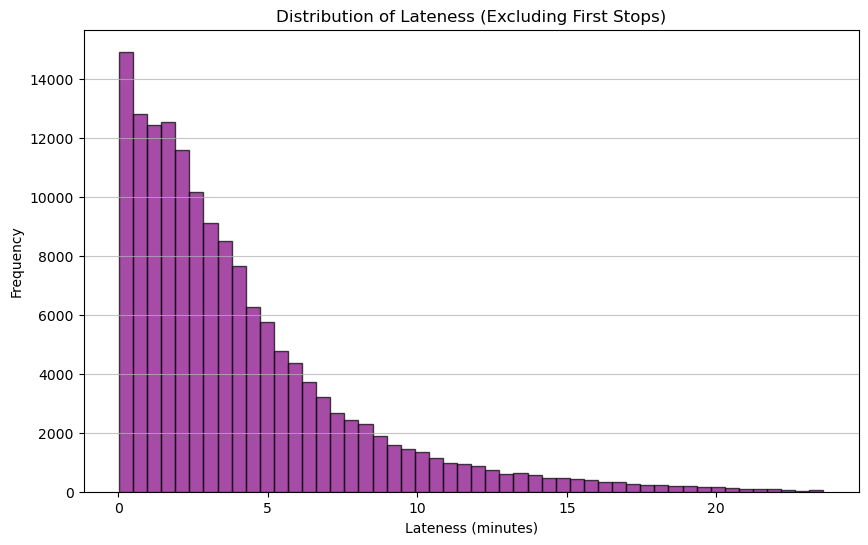

In [74]:
import matplotlib.pyplot as plt
# Adjust the lateness values where the lateness is greater than 50 minutes by subtracting 1440 minutes (24 hours)
df.loc[df['LATENESS'] > 50, 'LATENESS'] -= 1440

#re-check the lateness distribution for lateness greater than 0 minutes
lateness_positive_adjusted = df[(df['TRIP_EDGE'] != 1) & (df['LATENESS'] > 0)]['LATENESS']

# Plot the histogram for positive lateness values with the adjustment for midnight
plt.figure(figsize=(10, 6))
plt.hist(lateness_positive_adjusted, bins=50, color='purple', edgecolor='black', alpha=0.7)
plt.title('Distribution of Lateness (Excluding First Stops)')
plt.xlabel('Lateness (minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

# Show the histogram
plt.show()


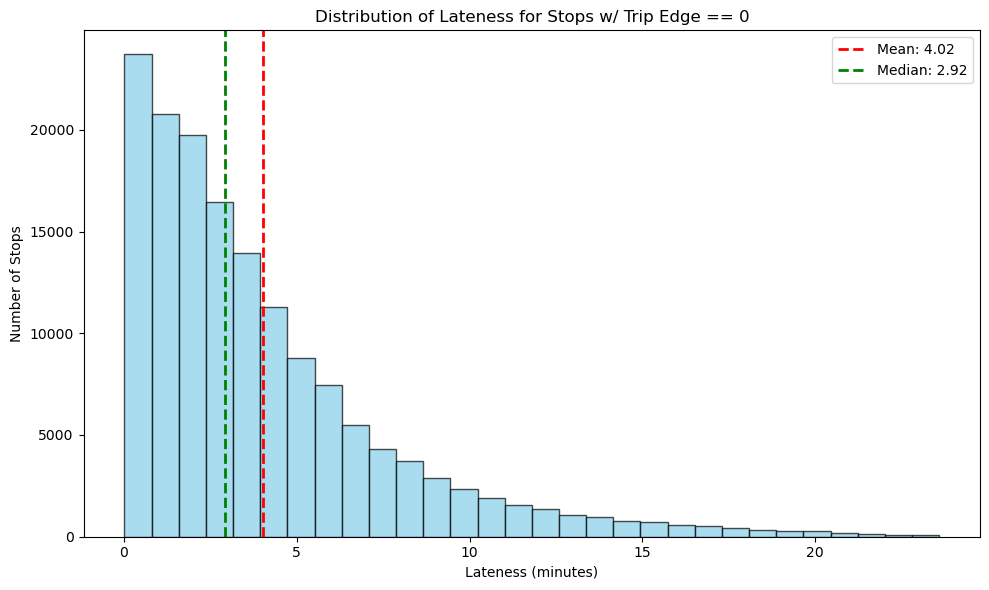

In [100]:
mean_lateness = lateness_positive_adjusted.mean()
median_lateness = lateness_positive_adjusted.median()

# Plot the histogram 
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(lateness_positive_adjusted, bins=30, color='skyblue', edgecolor='black', alpha=0.7)

# Highlight the mean and median
plt.axvline(mean_lateness, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {mean_lateness:.2f}')
plt.axvline(median_lateness, color='green', linestyle='dashed', linewidth=2, label=f'Median: {median_lateness:.2f}')

# Title and labels
plt.title('Distribution of Lateness for Stops w/ Trip Edge == 0')
plt.xlabel('Lateness (minutes)')
plt.ylabel('Number of Stops')


# Grid, legend, and tight layout for better spacing
# plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.tight_layout()

# Show the histogram
plt.show()


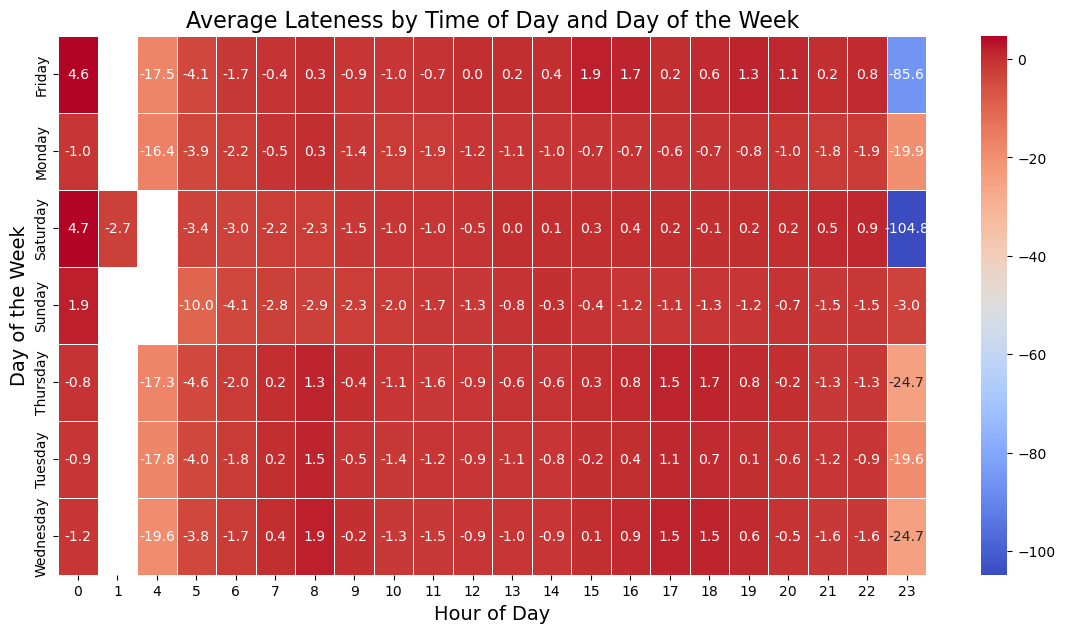

In [98]:
import seaborn as sns
# Assuming 'SCHEDULED_TIME' is already a datetime.time object
df_adjust['HOUR_OF_DAY'] = df_adjust['SCHEDULED_TIME'].apply(lambda x: x.hour if pd.notnull(x) else None)
df_adjust['DAY_OF_WEEK'] = df_adjust['DATE'].dt.day_name()

# Group by these new columns to calculate average lateness
grouped_lateness = df_adjust.groupby(['DAY_OF_WEEK', 'HOUR_OF_DAY'])['LATENESS'].mean().reset_index()

# Assuming 'grouped_lateness' is a DataFrame with 'DAY_OF_WEEK', 'HOUR_OF_DAY', and 'LATENESS' columns
lateness_pivot = grouped_lateness.pivot(index='DAY_OF_WEEK', columns='HOUR_OF_DAY', values='LATENESS')


# Plot the heatmap
plt.figure(figsize=(14, 7))
sns.heatmap(lateness_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=.5)

# Title and labels
plt.title('Average Lateness by Time of Day and Day of the Week', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Day of the Week', fontsize=14)

# Show the heatmap
plt.show()
